In [11]:
#libraries
import numpy as np
from scipy.integrate import solve_ivp
import scipy.interpolate as interpolate
import matplotlib.pyplot as plt

In [12]:
#general constants
g = 9.81
rocketDragCoef = 0.4
crossSectArea= 0.028
mInitial = 20
airBrakeCoeff = 2
airBrakeCrossSect = 0.015
rho_0 =  1.225
e = 2.718281828459045


In [29]:
#air density data
rawAirDensity = np.loadtxt(r"rocketData\air_density.csv", delimiter=',')  # Adjust skiprows based on your file's structure
airDensePoints = rawAirDensity.transpose()
#airDenseFunc = interpolate.CubicSpline(airDensePoints[0], airDensePoints[1])
a = 1.00367
b = -0.000101227
c = -0.000293537


def airDenseFunc(h):
    return a * e**(b*h)


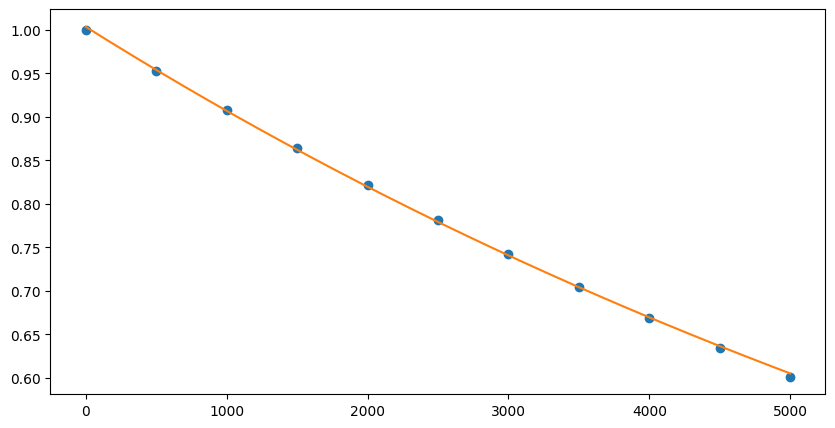

In [30]:
height =  np.linspace(0, 5000,5000)
sampleAirDensity = airDenseFunc(height)

plt.figure(figsize=(10,5))
plt.plot(airDensePoints[0], airDensePoints[1], 'o', label='Data Points')
plt.plot(height,sampleAirDensity)
plt.show()

In [39]:
#thrust data 
rawThrust = np.loadtxt(r'rocketData\thrust_curve.csv', delimiter=',')  # Adjust skiprows based on your file's structure
thrustPoints = rawThrust.transpose()
thrustFunc = interpolate.Akima1DInterpolator(thrustPoints[0], thrustPoints[1])

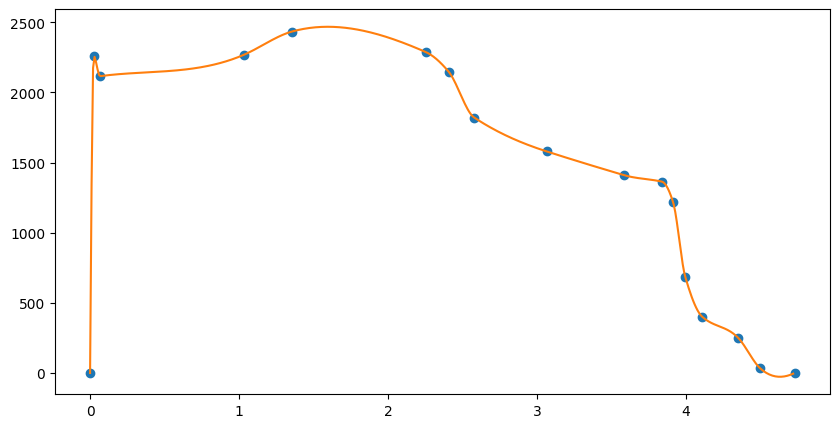

In [40]:
time =  np.linspace(0, 5, 500)
sampleThrust = thrustFunc(time)

plt.figure(figsize=(10,5))
plt.plot(thrustPoints[0], thrustPoints[1], 'o', label='Data Points')
plt.plot(time,sampleThrust)
plt.show()

In [41]:
#thrust curve 
def thrust(t):
    if t <= 4.729  and t >= 0:
        return thrustFunc(t)
    else:
        return 0 

In [42]:
#air density as a function of altitude 
def air_density(h):
    if (h >= 0 and h <= 5000):
        return rho_0 * airDenseFunc(h)
    
    elif():
        return

    else:
        return 0
    


In [43]:
def mass(t):
    burnRate = 3.717/4.5
    if t >= 0 and t <= 4.5:
        return mInitial - burnRate * t
    else:
        return mInitial - 3.717


In [44]:
#rocket drag given by velocity and height
def rocket_drag(v,h):
    rho = air_density(h)
    return 0.5 * rho * v**2 * rocketDragCoef * crossSectArea
    

In [45]:
def air_brake_drag(v,h,theta):
    rho = air_density(h)
    if 0 <= theta <= 1:
        return 0.5 * rho * v**2 * airBrakeCoeff * (airBrakeCrossSect * theta)
    else:
        return 0
    


In [46]:
def dynamic_equations(t,y,theta):
    h, v = y
    m = mass(t)
    T = thrust(t)
    D = rocket_drag(v, h)
    Dab= air_brake_drag(v,h,theta)
    dvdt = (T-D-Dab-m*g)/m
    dhdt = v

    return [dhdt, dvdt]




# PID control system

In [140]:
#simulation parameters
desired_apogee = 3000
Kp = 0.00003
Ki = 0.000002
Kd = 0.00000005

integral = 0
prevError = 0
deployment = 0

In [141]:
# PID control function
def pid_controller(setpoint, actual, prevError, integral, dt):
    error = setpoint - actual
    integral = error * dt
    derivative = (error - prevError)/dt
    output =  Kp * error + Ki * integral + Kd * derivative
    return output, error, integral

In [142]:
# Initial conditions
y0 = [0, 0]  # initial altitude and velocity
t_span = (0, 120)  # time span for the simulation

In [143]:
# Time points for output
tPoints = np.linspace(t_span[0], t_span[1], 1200)

# Running the simulation 

In [144]:
# run the simulation with the PID control system
results = []
height = []
vel = []
for i in range(len(tPoints)):
    currentTime = tPoints[i]
    if i == 0:
        currentState = y0
        dt = tPoints[1]-tPoints[0]
    else:
        dt = tPoints[i] - tPoints[i-1]
    
    deployment, prevError, integral = pid_controller(desired_apogee,currentState[0], prevError, integral, dt)
    deployment = max(0,min(deployment, 1))

    print(f"Time: {currentTime}, Deployment Length: {deployment}, Altitude: {currentState[0]}, Velocity: {currentState[1]}")


    
    solution = solve_ivp(dynamic_equations, [currentTime, currentTime + dt], currentState, args= (deployment,), t_eval= [currentTime + dt])
    
    currentState = np.array(solution.y[:, -1])
    currentTime = np.array(solution.t[0])


    if currentState[0] >= 0:
        height.append(currentState[0])
        vel.append(currentState[1])


    else:
        height.append(0)
        vel.append(0)
    


Time: 0.0, Deployment Length: 0.09209925041701417, Altitude: 0, Velocity: 0
Time: 0.10008340283569642, Deployment Length: 0.09058786213389873, Altitude: 0.41167381031522676, Velocity: 8.945237156883678
Time: 0.20016680567139283, Deployment Length: 0.0905456802036113, Altitude: 1.7923884894217177, Velocity: 18.660325686239872
Time: 0.3002502085070893, Deployment Length: 0.09047401396344412, Altitude: 4.149281359276623, Velocity: 28.448542325520325
Time: 0.40033361134278567, Deployment Length: 0.09037267446294708, Altitude: 7.488623354865798, Velocity: 38.29044578098146
Time: 0.5004170141784821, Deployment Length: 0.0902415181137134, Altitude: 11.815193709268646, Velocity: 48.175699269357054
Time: 0.6005004170141786, Deployment Length: 0.09008041813171098, Altitude: 17.133200002568774, Velocity: 58.103241208313456
Time: 0.700583819849875, Deployment Length: 0.0898892362828669, Altitude: 23.44721348076024, Velocity: 68.08141933441044
Time: 0.8006672226855713, Deployment Length: 0.08966779

In [145]:
# Extract results for plotting
#h = [state[0] for state in results]
#v = [state[1] for state in results]

h = height
v = vel


In [146]:
height

[0.41167381031522676,
 1.7923884894217177,
 4.149281359276623,
 7.488623354865798,
 11.815193709268646,
 17.133200002568774,
 23.44721348076024,
 30.763115891137275,
 39.08905391454951,
 48.43639712153544,
 58.82072632360793,
 70.26307850172195,
 82.78774244967465,
 96.41466915019348,
 111.1531558842222,
 127.0031753122309,
 143.95729073990017,
 162.001351571193,
 181.1151862347876,
 201.27331802980913,
 222.44569905032114,
 244.59845725457978,
 267.69454670465905,
 291.68814522387146,
 316.50586762328805,
 342.03027058872567,
 368.1692972177501,
 394.8758471651346,
 422.11062398549967,
 449.83911043940856,
 478.03082358212913,
 506.65830437836877,
 535.6954820337322,
 565.1170641020076,
 594.8984917874596,
 625.0159052653132,
 655.4471484974256,
 686.176246933943,
 717.1874835351483,
 748.3753305092338,
 779.4449465812007,
 810.2390804621333,
 840.7178862156761,
 870.8569997301953,
 900.5966617409346,
 929.8671463893659,
 958.6485379261292,
 986.9599600515859,
 1014.8217822621463,
 10

In [147]:
maxHeight = max(h)
maxVel = max(v)

print(maxHeight)
print(maxVel)


2787.8960423317203
311.4546949511631


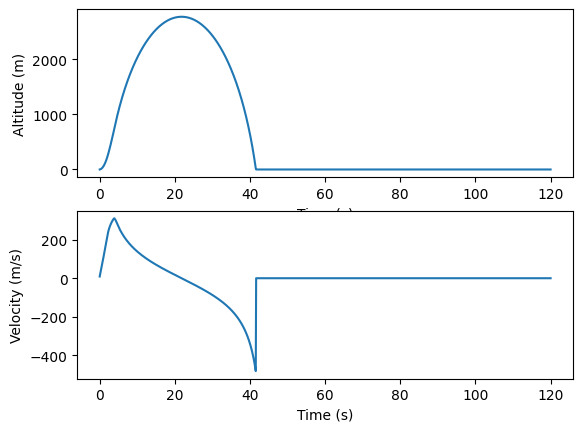

In [139]:
# Plotting results
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(tPoints, h)
plt.xlabel('Time (s)')
plt.ylabel('Altitude (m)')
plt.subplot(2, 1, 2)
plt.plot(tPoints, v)
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.show()